In [1]:
!pip install tensorflow
!pip install scipy
!pip install pynrrd

In [59]:
%matplotlib inline

In [61]:
!pip install ipywidgets --upgrade
!pip install matplotlib --upgrade

   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 18.9 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 1.0.0
    Uninstalling jupyterlab-widgets-1.0.0:
      Successfully uninstalled jupyterlab-widgets-1.0.0
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.8.1
    Uninstalling ipywidgets-7.8.1:
      Successfully uninstalled ipywidgets-7.8.1
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------- ----------------- 4.5/8.1 MB 26.9 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 25.0 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installat

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\users\\clarynse\\anaconda3\\lib\\site-packages\\matplotlib\\backends\\_backend_agg.cp312-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import pandas as pd
import SimpleITK as sitk
from matplotlib import pyplot as plt
from scipy import ndimage
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import math
from skimage.filters import threshold_mean
import cv2

C:\Users\clarynse\AppData\Local\Temp\ipykernel_18584\1494234353.py:8: DeprecationWarning: Please import `map_coordinates` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import map_coordinates
C:\Users\clarynse\AppData\Local\Temp\ipykernel_18584\1494234353.py:9: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [5]:
import SimpleITK as sitk
from ipywidgets import interact
print(sitk.Version())

SimpleITK Version: 2.4.1 (ITK 5.4)
Compiled: Jan  9 2025 14:48:38



In [7]:
import os
dataset_path = "C:/Users/clarynse/HN_CHUS_Laryngeal_Cancer/Raw_images"

In [9]:
# Check if required directories exist
print("Dataset Path Exists:", os.path.exists(dataset_path))

Dataset Path Exists: True


In [11]:
# List files in Raw_images folder
print("\nFiles in Raw_images folder:", os.listdir(dataset_path))


Files in Raw_images folder: ['HN_CHUS_001', 'HN_CHUS_002', 'HN_CHUS_011', 'HN_CHUS_012', 'HN_CHUS_017', 'HN_CHUS_018', 'HN_CHUS_023', 'HN_CHUS_024', 'HN_CHUS_029', 'HN_CHUS_032', 'HN_CHUS_034', 'HN_CHUS_037', 'HN_CHUS_044', 'HN_CHUS_054', 'HN_CHUS_062', 'HN_CHUS_063', 'HN_CHUS_070', 'HN_CHUS_071', 'HN_CHUS_072', 'HN_CHUS_075', 'HN_CHUS_084', 'HN_CHUS_099']


In [13]:
import SimpleITK as sitk
import os

# Define input and output paths
dicom_root = "C:/Users/clarynse/HN_CHUS_Laryngeal_Cancer/Raw_images"  # Root folder containing subfolders with DICOM images
output_dir = "C:/Users/clarynse/HN_CHUS_Laryngeal_Cancer/2D_model/Processed_nii_images"  # Folder to save converted 3D images
os.makedirs(output_dir, exist_ok=True)

# Iterate through each patient folder
for patient_folder in os.listdir(dicom_root):
    dicom_path = os.path.join(dicom_root, patient_folder)
    
    if os.path.isdir(dicom_path):  # Ensure it's a directory
        reader = sitk.ImageSeriesReader()
        dicom_series = reader.GetGDCMSeriesFileNames(dicom_path)
        
        if not dicom_series:
            print(f"Skipping {patient_folder}, no DICOM files found.")
            continue

        reader.SetFileNames(dicom_series)
        image = reader.Execute()

        # Save as .nii
        nii_path = os.path.join(output_dir, f"{patient_folder}.nii.gz")
        sitk.WriteImage(image, nii_path)

        print(f"Saved {patient_folder} as .nii")

Saved HN_CHUS_001 as .nii
Saved HN_CHUS_002 as .nii
Saved HN_CHUS_011 as .nii
Saved HN_CHUS_012 as .nii
Saved HN_CHUS_017 as .nii
Saved HN_CHUS_018 as .nii
Saved HN_CHUS_023 as .nii
Saved HN_CHUS_024 as .nii
Saved HN_CHUS_029 as .nii
Saved HN_CHUS_032 as .nii
Saved HN_CHUS_034 as .nii
Saved HN_CHUS_037 as .nii
Saved HN_CHUS_044 as .nii
Saved HN_CHUS_054 as .nii
Saved HN_CHUS_062 as .nii
Saved HN_CHUS_063 as .nii
Saved HN_CHUS_070 as .nii
Saved HN_CHUS_071 as .nii
Saved HN_CHUS_072 as .nii
Saved HN_CHUS_075 as .nii
Saved HN_CHUS_084 as .nii
Saved HN_CHUS_099 as .nii


In [15]:
#Extracting Metadata from the original nii images

def extract_metadata(image_path):
    image = sitk.ReadImage(image_path)
    spacing = image.GetSpacing()  # (x, y, z) voxel spacing
    size = image.GetSize()  # (x, y, z) dimensions
    direction = image.GetDirection()  # Image orientation
    origin = image.GetOrigin()  # Physical coordinates of origin
    
    print(f"File: {image_path}")
    print(f"Voxel Spacing: {spacing}")
    print(f"Size: {size}")
    print(f"Direction: {direction}")
    print(f"Origin: {origin}")
    print("-" * 50)

# Apply to all converted images
for file in os.listdir(output_dir):
    if file.endswith(".nii.gz"):
        extract_metadata(os.path.join(output_dir, file))

File: C:/Users/clarynse/HN_CHUS_Laryngeal_Cancer/2D_model/Processed_nii_images\HN_CHUS_001.nii.gz
Voxel Spacing: (1.171875, 1.171875, 3.0)
Size: (512, 512, 132)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)
Origin: (-300.0, -230.0, -551.5)
--------------------------------------------------
File: C:/Users/clarynse/HN_CHUS_Laryngeal_Cancer/2D_model/Processed_nii_images\HN_CHUS_002.nii.gz
Voxel Spacing: (1.171875, 1.171875, 3.0)
Size: (512, 512, 132)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)
Origin: (-300.0, -230.0, -552.0)
--------------------------------------------------
File: C:/Users/clarynse/HN_CHUS_Laryngeal_Cancer/2D_model/Processed_nii_images\HN_CHUS_011.nii.gz
Voxel Spacing: (1.171875, 1.171875, 2.0)
Size: (512, 512, 173)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)
Origin: (-300.0, -230.0, -298.0)
--------------------------------------------------
File: C:/Users/clarynse/HN_CHUS_Laryngeal_Cancer/2D_model/Processed_nii_images\HN_CHUS_012.

In [21]:
import SimpleITK as sitk
import os

# Define directories
input_dir = "C:/Users/clarynse/HN_CHUS_Laryngeal_Cancer/2D_model/Processed_nii_images"  # Folder where original converted images are stored
resampled_dir = "resampled_1mm"  # Folder to store resampled images

# Create output directory if it doesn't exist
os.makedirs(resampled_dir, exist_ok=True)

def resample_image(image, new_spacing=(1.0, 1.0, 1.0)):
    """
    Resample the given image to the specified new_spacing while maintaining the original direction and origin.
    """
    old_spacing = image.GetSpacing()
    old_size = image.GetSize()

    # Compute new size to maintain the aspect ratio
    new_size = [
        int(round(old_size[i] * (old_spacing[i] / new_spacing[i])))
        for i in range(3)
    ]

    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(new_size)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetOutputOrigin(image.GetOrigin())
    
    return resampler.Execute(image)

# Apply resampling to all images
for file in os.listdir(input_dir):
    if file.endswith(".nii.gz"):
        img_path = os.path.join(input_dir, file)
        img = sitk.ReadImage(img_path)

        resampled_img = resample_image(img)
        
        # Save resampled image to "resampled_1mm" folder with the same filename
        resampled_path = os.path.join(resampled_dir, file)
        sitk.WriteImage(resampled_img, resampled_path)
        
        print(f"Resampled {file} and saved to {resampled_path}")


Resampled HN_CHUS_001.nii.gz and saved to resampled_1mm\HN_CHUS_001.nii.gz
Resampled HN_CHUS_002.nii.gz and saved to resampled_1mm\HN_CHUS_002.nii.gz
Resampled HN_CHUS_011.nii.gz and saved to resampled_1mm\HN_CHUS_011.nii.gz
Resampled HN_CHUS_012.nii.gz and saved to resampled_1mm\HN_CHUS_012.nii.gz
Resampled HN_CHUS_017.nii.gz and saved to resampled_1mm\HN_CHUS_017.nii.gz
Resampled HN_CHUS_018.nii.gz and saved to resampled_1mm\HN_CHUS_018.nii.gz
Resampled HN_CHUS_023.nii.gz and saved to resampled_1mm\HN_CHUS_023.nii.gz
Resampled HN_CHUS_024.nii.gz and saved to resampled_1mm\HN_CHUS_024.nii.gz
Resampled HN_CHUS_029.nii.gz and saved to resampled_1mm\HN_CHUS_029.nii.gz
Resampled HN_CHUS_032.nii.gz and saved to resampled_1mm\HN_CHUS_032.nii.gz
Resampled HN_CHUS_034.nii.gz and saved to resampled_1mm\HN_CHUS_034.nii.gz
Resampled HN_CHUS_037.nii.gz and saved to resampled_1mm\HN_CHUS_037.nii.gz
Resampled HN_CHUS_044.nii.gz and saved to resampled_1mm\HN_CHUS_044.nii.gz
Resampled HN_CHUS_054.nii

In [23]:
#Extracting metadata from the resampled 1mm images

import SimpleITK as sitk
import os

# Define the directory containing resampled images
resampled_dir = "resampled_1mm"

# Function to extract metadata
def extract_metadata(image_path):
    image = sitk.ReadImage(image_path)

    metadata = {
        "File Name": os.path.basename(image_path),
        "Image Size": image.GetSize(),  # (Width, Height, Depth)
        "Voxel Spacing": image.GetSpacing(),  # (SpacingX, SpacingY, SpacingZ)
        "Origin": image.GetOrigin(),  # (X, Y, Z)
        "Direction": image.GetDirection()  # Orientation matrix
    }

    return metadata

# Process all images in the resampled directory
metadata_list = []
for file in os.listdir(resampled_dir):
    if file.endswith(".nii.gz"):
        img_path = os.path.join(resampled_dir, file)
        metadata = extract_metadata(img_path)
        metadata_list.append(metadata)

        # Print metadata for each image
        print("\n--- Metadata for:", metadata["File Name"], "---")
        for key, value in metadata.items():
            if key != "File Name":  # Skip printing filename again
                print(f"{key}: {value}")

# If you need to save metadata to a CSV file
import pandas as pd
df = pd.DataFrame(metadata_list)
df.to_csv("resampled_metadata.csv", index=False)
print("\nMetadata saved to 'resampled_metadata.csv'.")



--- Metadata for: HN_CHUS_001.nii.gz ---
Image Size: (600, 600, 396)
Voxel Spacing: (1.0, 1.0, 1.0)
Origin: (-300.0, -230.0, -551.5)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)

--- Metadata for: HN_CHUS_002.nii.gz ---
Image Size: (600, 600, 396)
Voxel Spacing: (1.0, 1.0, 1.0)
Origin: (-300.0, -230.0, -552.0)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)

--- Metadata for: HN_CHUS_011.nii.gz ---
Image Size: (600, 600, 346)
Voxel Spacing: (1.0, 1.0, 1.0)
Origin: (-300.0, -230.0, -298.0)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)

--- Metadata for: HN_CHUS_012.nii.gz ---
Image Size: (600, 600, 412)
Voxel Spacing: (1.0, 1.0, 1.0)
Origin: (-300.0, -230.0, -360.0)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)

--- Metadata for: HN_CHUS_017.nii.gz ---
Image Size: (600, 600, 472)
Voxel Spacing: (1.0, 1.0, 1.0)
Origin: (-300.0, -230.0, -407.0)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)

--- Metadata for: HN_CHUS_018.nii.gz --

In [22]:
import SimpleITK as sitk
import os
import numpy as np

# Define directories
resampled_dir = "resampled_1mm"
cropped_dir = "cropped_1mm"

# Create output directory if it doesn't exist
os.makedirs(cropped_dir, exist_ok=True)

# Define cropping region
x1, x2 = 236, 364
y1, y2 = 166, 294
original_slice_range = (150, 300)  # Slice range in the original images

def crop_image(image, original_spacing, new_spacing=(1.0, 1.0, 1.0)):
    """
    Crops the image based on the given coordinates and adjusts the slice range
    according to the resampled 1mm slices.
    """
    # Compute corresponding Z indices in the resampled image
    z1 = int(round(original_slice_range[0] * original_spacing[2] / new_spacing[2]))
    z2 = int(round(original_slice_range[1] * original_spacing[2] / new_spacing[2]))

    # Ensure indices are within bounds
    size = image.GetSize()
    z1 = max(0, min(z1, size[2] - 1))
    z2 = max(0, min(z2, size[2] - 1))

    # Extract numpy array and crop
    image_array = sitk.GetArrayFromImage(image)  # Shape: (Depth, Height, Width)
    cropped_array = image_array[z1:z2, y1:y2, x1:x2]

    # Convert back to SimpleITK image
    cropped_image = sitk.GetImageFromArray(cropped_array)
    cropped_image.SetSpacing(new_spacing)
    cropped_image.SetOrigin(image.GetOrigin())
    cropped_image.SetDirection(image.GetDirection())

    return cropped_image

# Apply cropping to all resampled images
for file in os.listdir(resampled_dir):
    if file.endswith(".nii.gz"):
        img_path = os.path.join(resampled_dir, file)
        image = sitk.ReadImage(img_path)

        # Extract original spacing (before resampling) from metadata
        original_spacing = image.GetSpacing()

        cropped_img = crop_image(image, original_spacing)

        # Save cropped image
        cropped_path = os.path.join(cropped_dir, file.replace(".nii.gz", "_cropped.nii.gz"))
        sitk.WriteImage(cropped_img, cropped_path)

        print(f"Cropped {file} and saved to {cropped_path}")


Cropped HN_CHUS_001.nii.gz and saved to cropped_1mm\HN_CHUS_001_cropped.nii.gz
Cropped HN_CHUS_002.nii.gz and saved to cropped_1mm\HN_CHUS_002_cropped.nii.gz
Cropped HN_CHUS_011.nii.gz and saved to cropped_1mm\HN_CHUS_011_cropped.nii.gz
Cropped HN_CHUS_012.nii.gz and saved to cropped_1mm\HN_CHUS_012_cropped.nii.gz
Cropped HN_CHUS_017.nii.gz and saved to cropped_1mm\HN_CHUS_017_cropped.nii.gz
Cropped HN_CHUS_018.nii.gz and saved to cropped_1mm\HN_CHUS_018_cropped.nii.gz
Cropped HN_CHUS_023.nii.gz and saved to cropped_1mm\HN_CHUS_023_cropped.nii.gz
Cropped HN_CHUS_024.nii.gz and saved to cropped_1mm\HN_CHUS_024_cropped.nii.gz
Cropped HN_CHUS_029.nii.gz and saved to cropped_1mm\HN_CHUS_029_cropped.nii.gz
Cropped HN_CHUS_032.nii.gz and saved to cropped_1mm\HN_CHUS_032_cropped.nii.gz
Cropped HN_CHUS_034.nii.gz and saved to cropped_1mm\HN_CHUS_034_cropped.nii.gz
Cropped HN_CHUS_037.nii.gz and saved to cropped_1mm\HN_CHUS_037_cropped.nii.gz
Cropped HN_CHUS_044.nii.gz and saved to cropped_1mm\

Visualizing: HN_CHUS_001_cropped.nii.gz
Image Shape: Depth=150, Height=128, Width=128


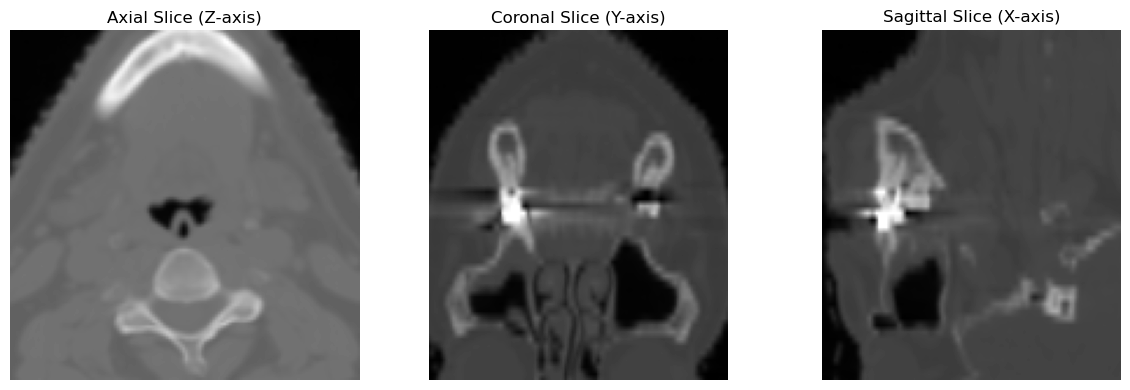

Visualizing: HN_CHUS_002_cropped.nii.gz
Image Shape: Depth=150, Height=128, Width=128


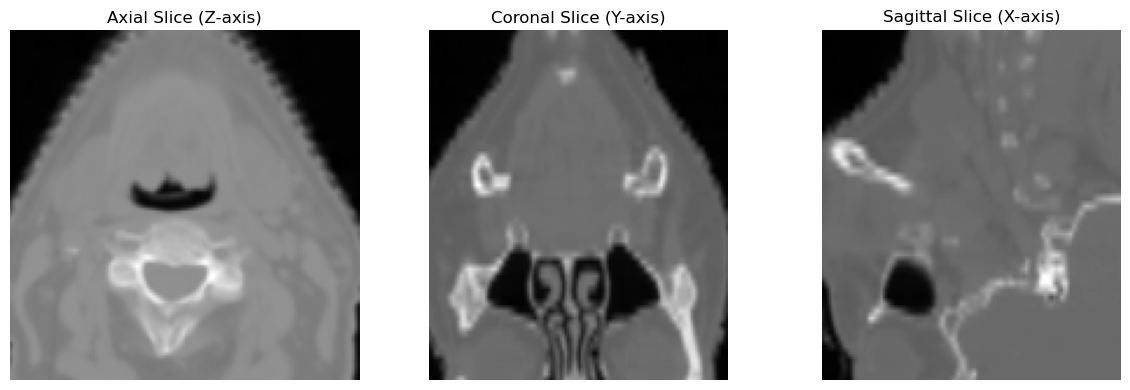

Visualizing: HN_CHUS_011_cropped.nii.gz
Image Shape: Depth=150, Height=128, Width=128


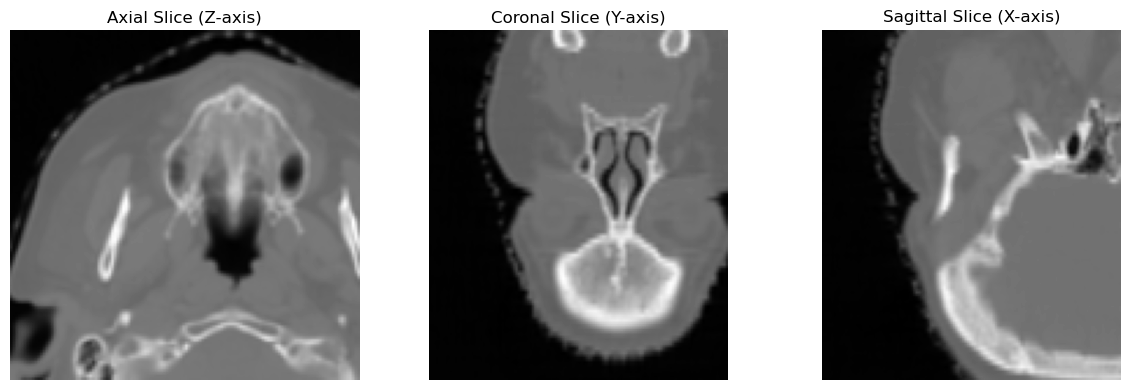

Visualizing: HN_CHUS_012_cropped.nii.gz
Image Shape: Depth=150, Height=128, Width=128


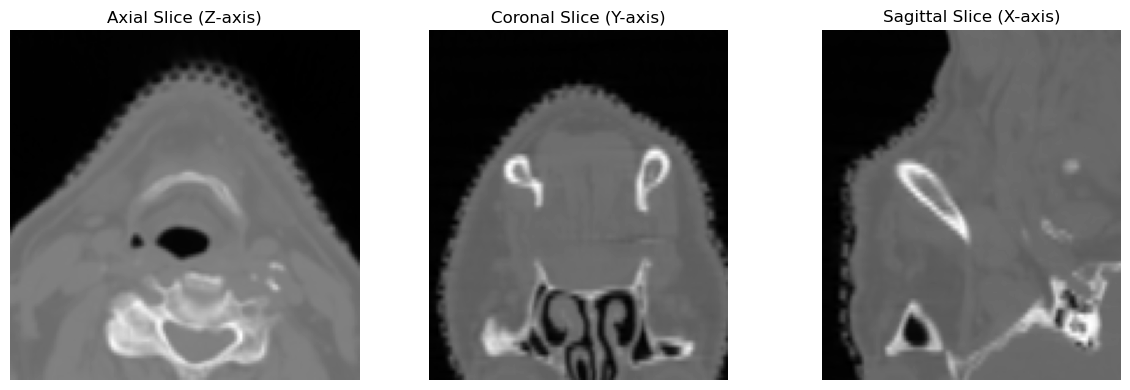

Visualizing: HN_CHUS_017_cropped.nii.gz
Image Shape: Depth=150, Height=128, Width=128


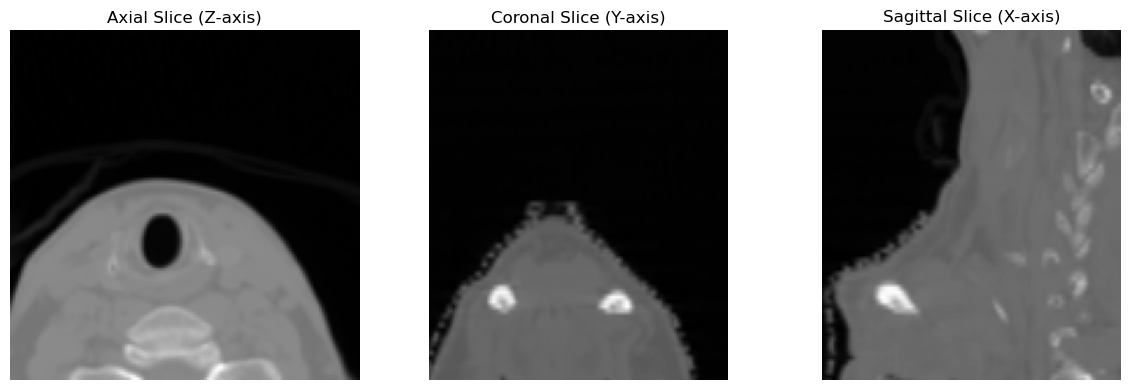

Visualizing: HN_CHUS_018_cropped.nii.gz
Image Shape: Depth=150, Height=128, Width=128


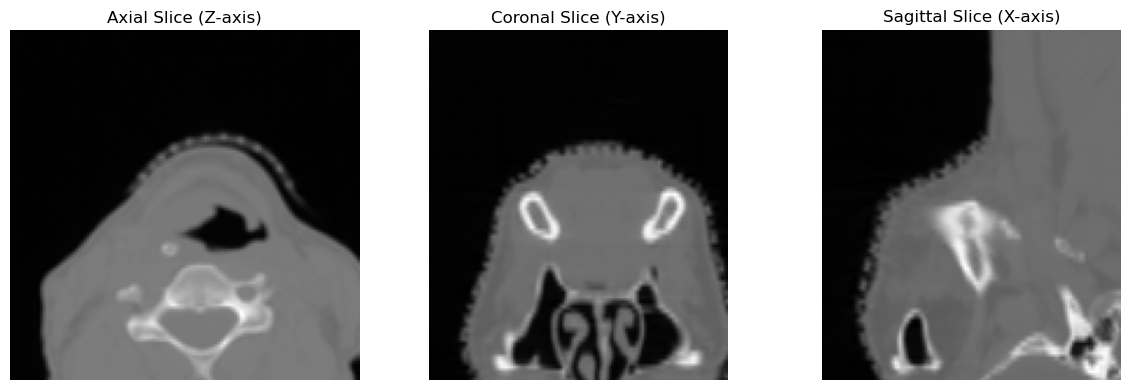

Visualizing: HN_CHUS_023_cropped.nii.gz
Image Shape: Depth=150, Height=128, Width=128


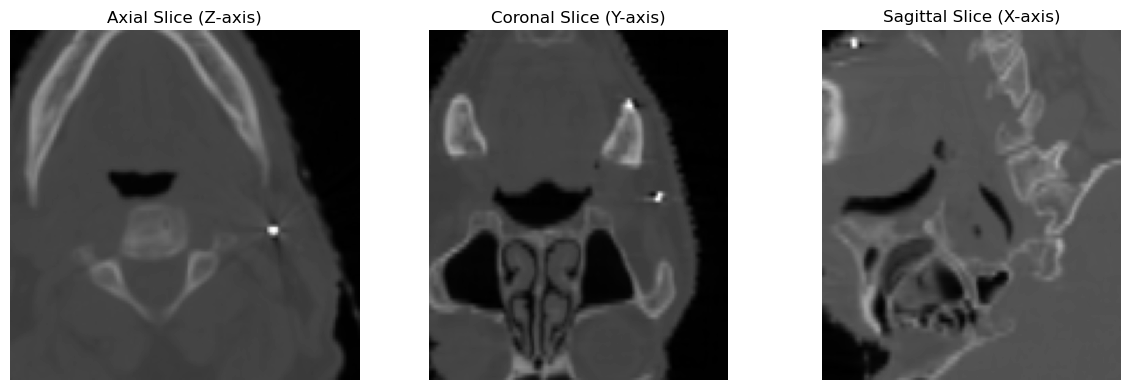

Visualizing: HN_CHUS_024_cropped.nii.gz
Image Shape: Depth=150, Height=128, Width=128


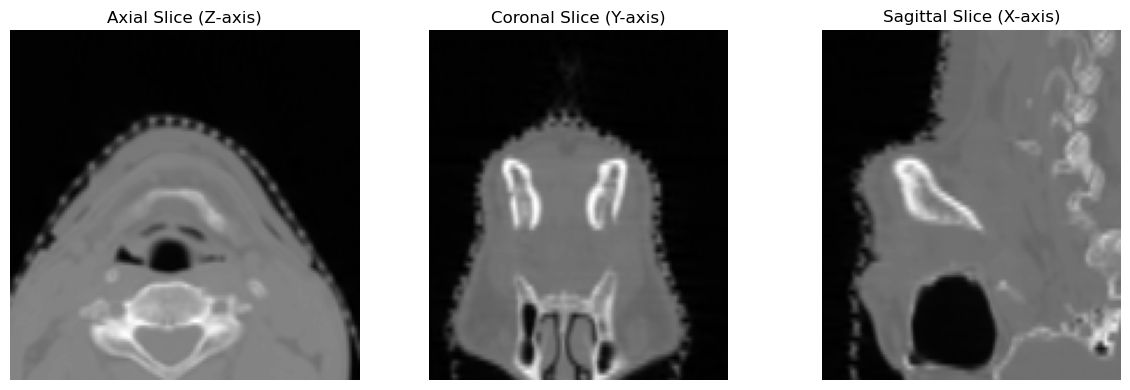

Visualizing: HN_CHUS_029_cropped.nii.gz
Image Shape: Depth=150, Height=128, Width=128


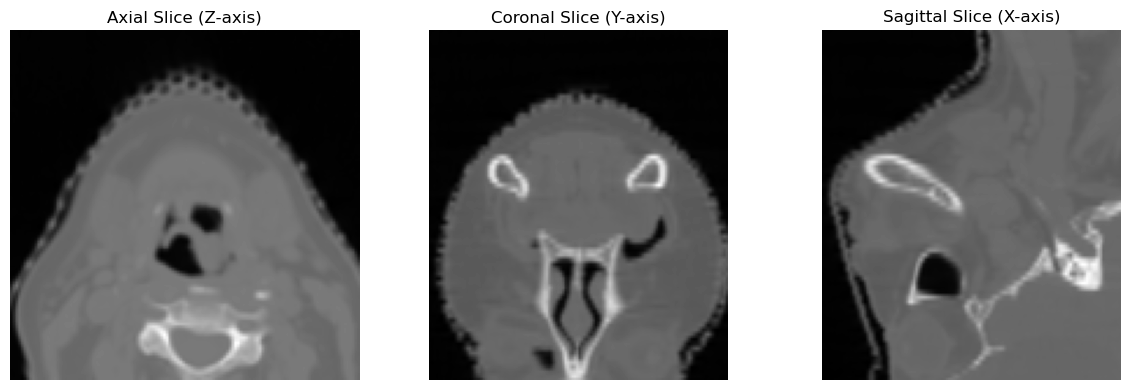

Visualizing: HN_CHUS_032_cropped.nii.gz
Image Shape: Depth=150, Height=128, Width=128


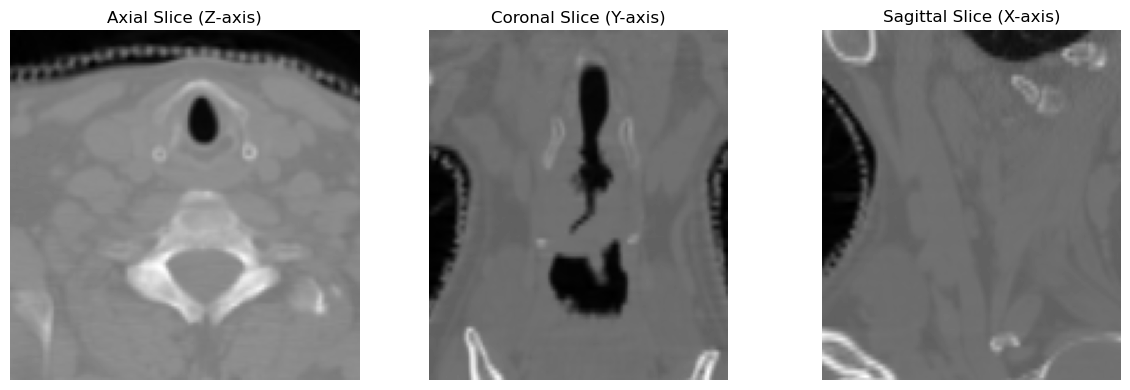

Visualizing: HN_CHUS_034_cropped.nii.gz
Image Shape: Depth=150, Height=128, Width=128


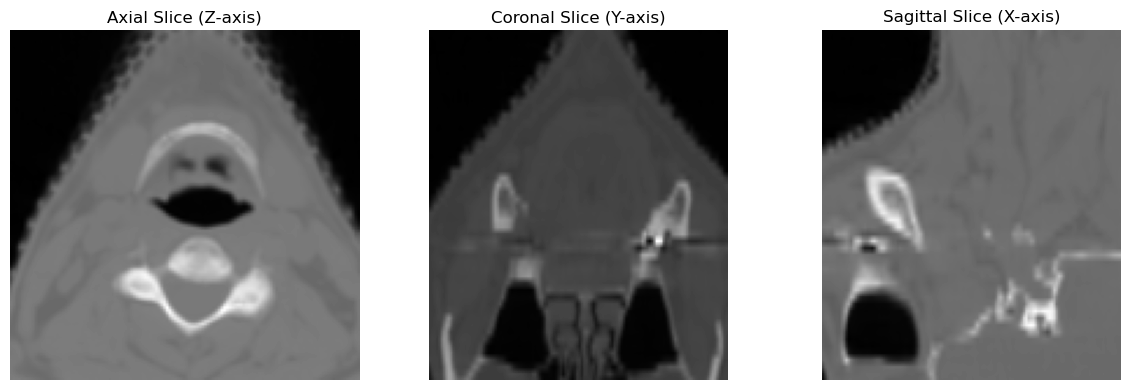

Visualizing: HN_CHUS_037_cropped.nii.gz
Image Shape: Depth=150, Height=128, Width=128


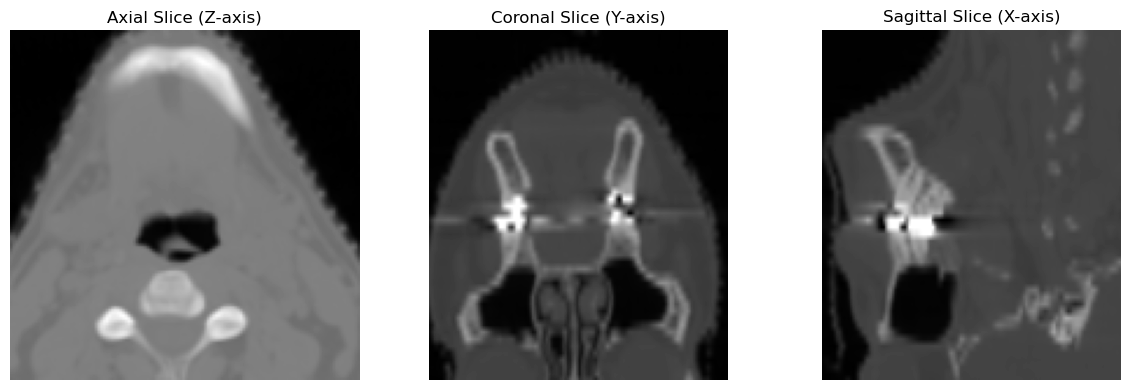

Visualizing: HN_CHUS_044_cropped.nii.gz
Image Shape: Depth=150, Height=128, Width=128


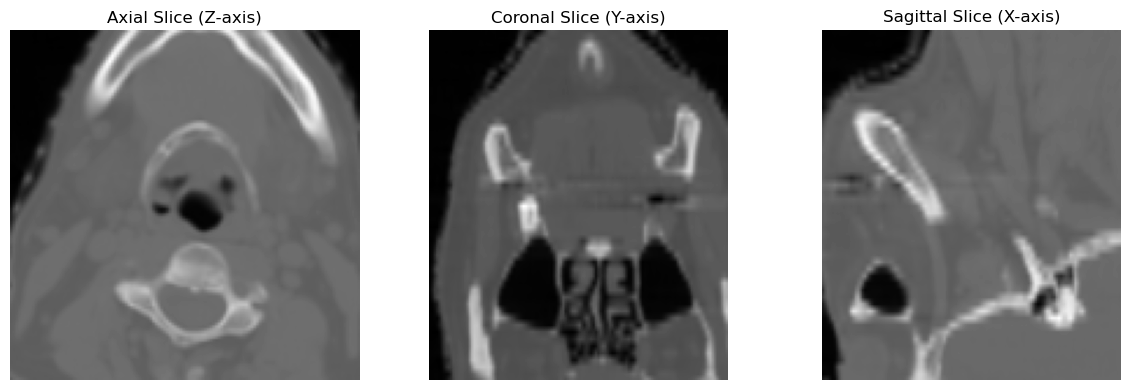

Visualizing: HN_CHUS_054_cropped.nii.gz
Image Shape: Depth=150, Height=128, Width=128


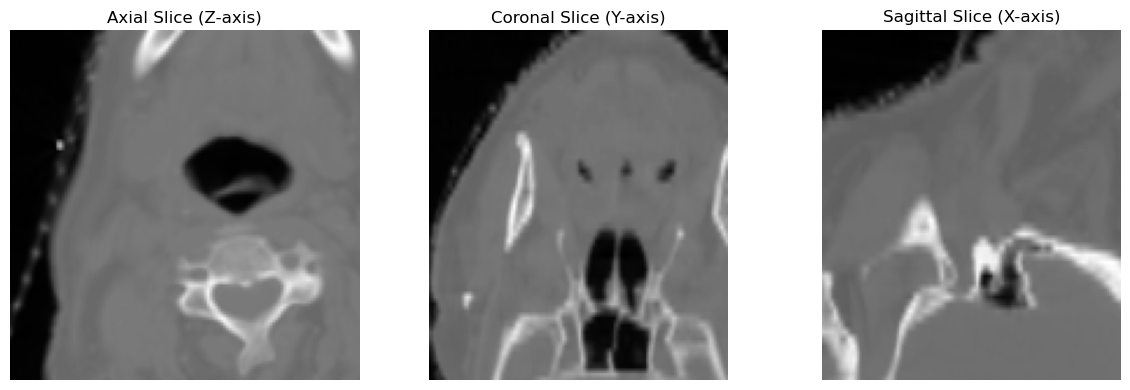

Visualizing: HN_CHUS_062_cropped.nii.gz
Image Shape: Depth=150, Height=128, Width=128


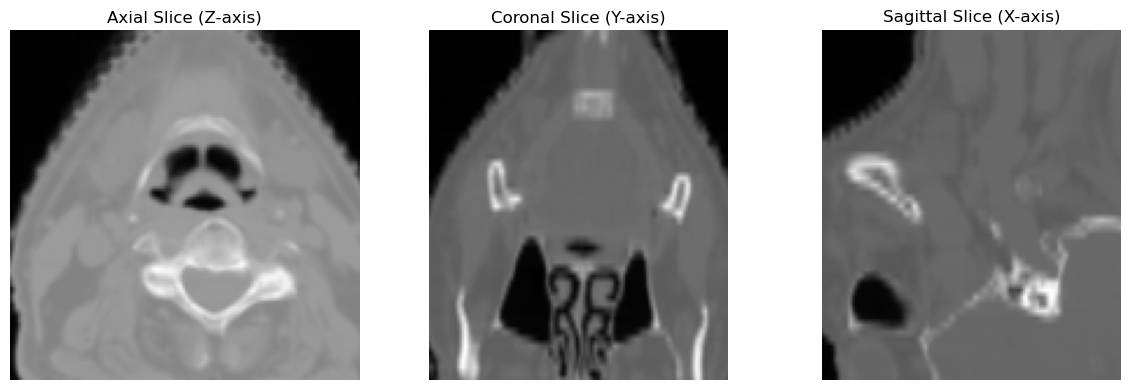

Visualizing: HN_CHUS_063_cropped.nii.gz
Image Shape: Depth=150, Height=128, Width=128


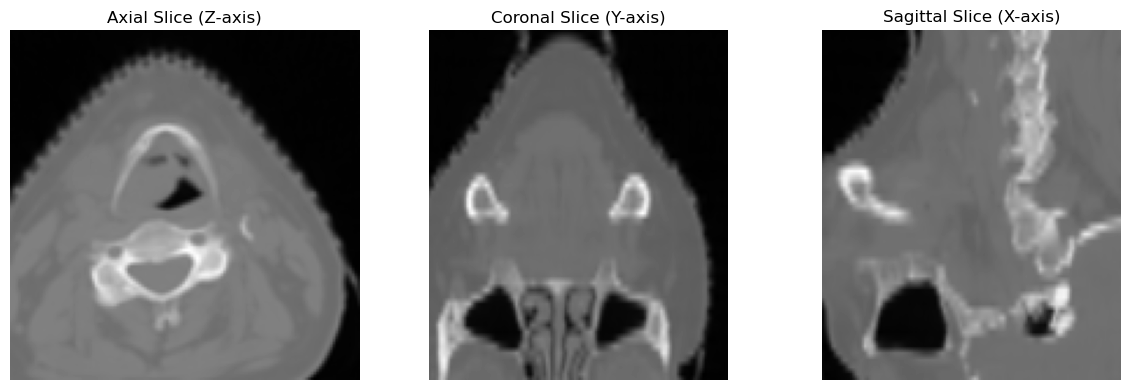

Visualizing: HN_CHUS_070_cropped.nii.gz
Image Shape: Depth=150, Height=128, Width=128


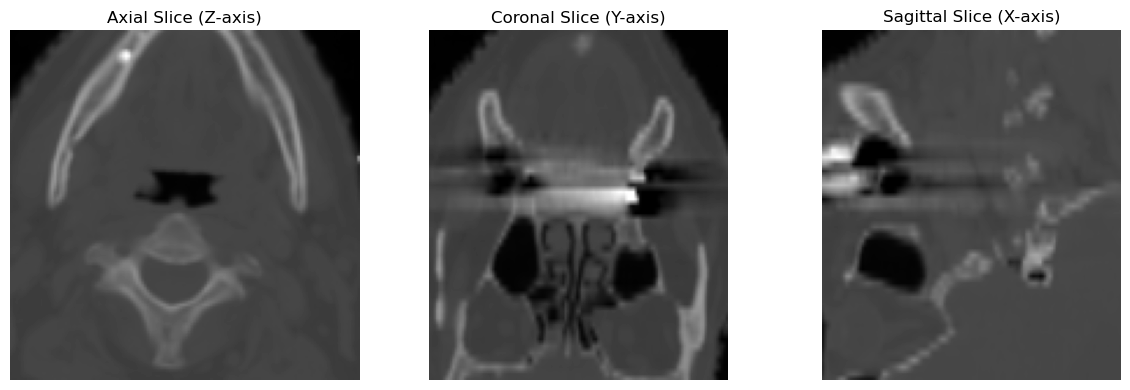

Visualizing: HN_CHUS_071_cropped.nii.gz
Image Shape: Depth=150, Height=128, Width=128


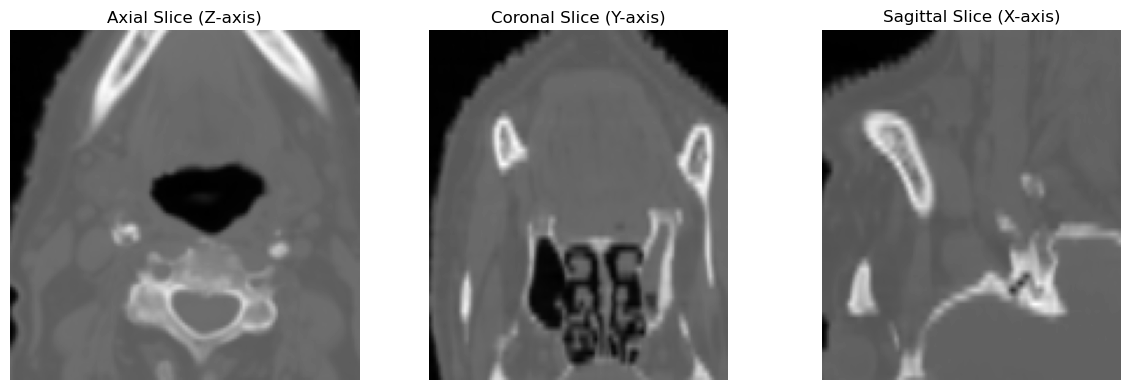

Visualizing: HN_CHUS_072_cropped.nii.gz
Image Shape: Depth=150, Height=128, Width=128


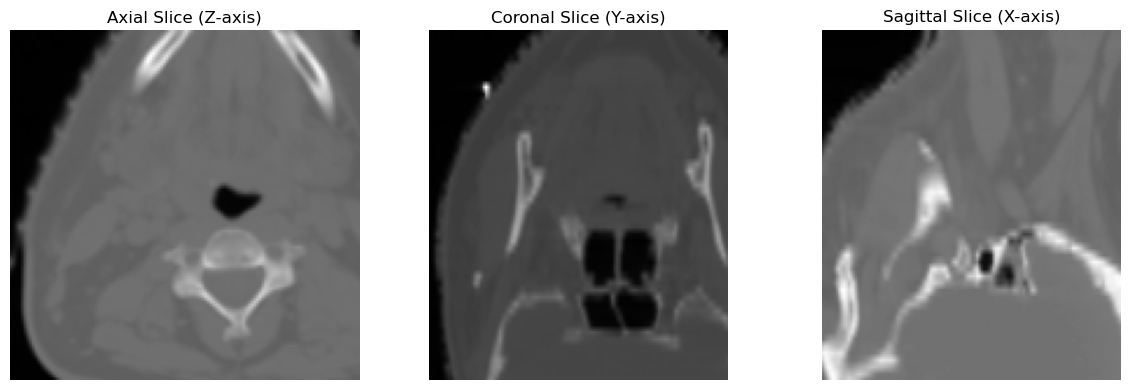

Visualizing: HN_CHUS_075_cropped.nii.gz
Image Shape: Depth=150, Height=128, Width=128


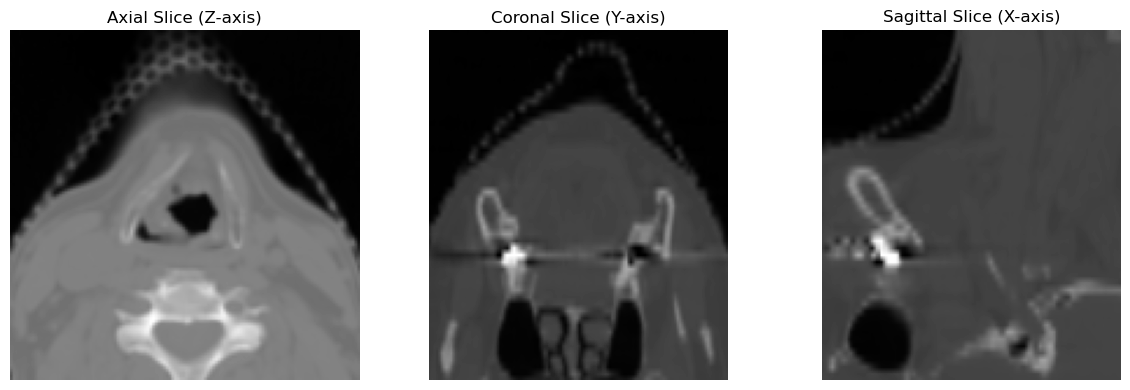

Visualizing: HN_CHUS_084_cropped.nii.gz
Image Shape: Depth=150, Height=128, Width=128


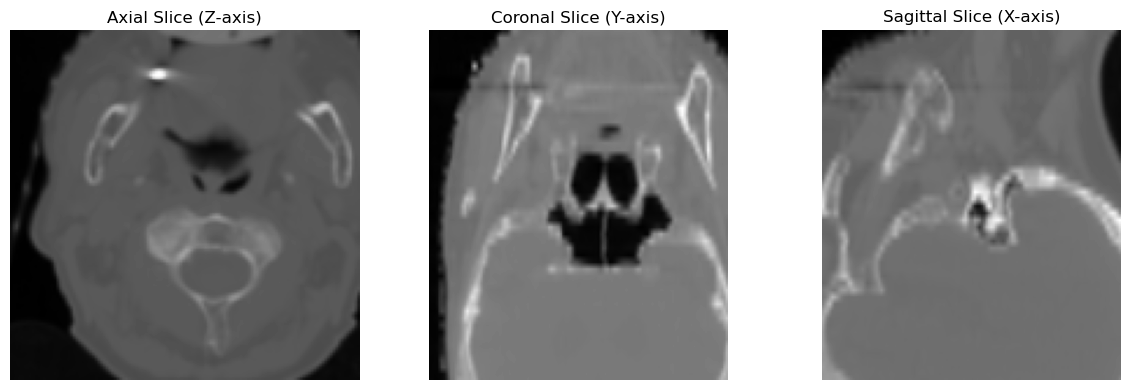

Visualizing: HN_CHUS_099_cropped.nii.gz
Image Shape: Depth=150, Height=128, Width=128


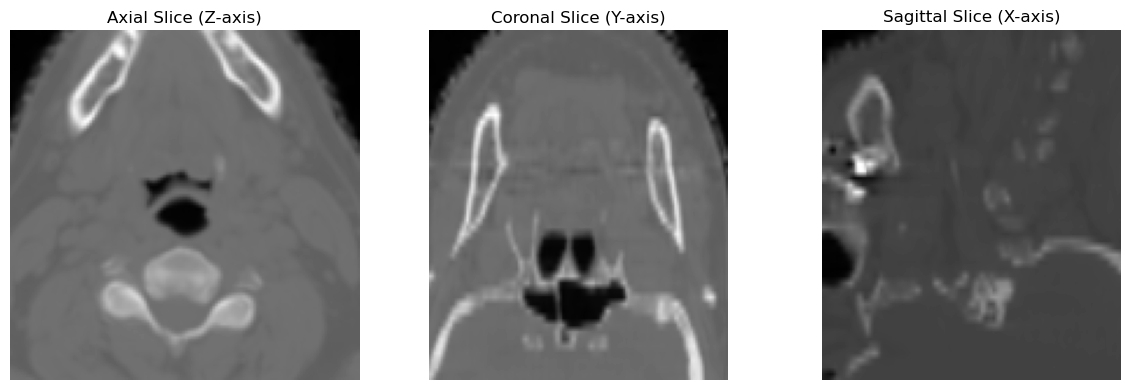

In [24]:
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt

# Define directory where the cropped images are stored
cropped_dir = "cropped_1mm"  # Adjust path as needed

# Function to visualize a single cropped image in 2D slices
def visualize_2d_slices(image_path):
    # Read the cropped image
    image = sitk.ReadImage(image_path)

    # Convert the image to a numpy array (shape: Depth, Height, Width)
    image_array = sitk.GetArrayFromImage(image)
    
    # Get the shape of the image (Depth, Height, Width)
    depth, height, width = image_array.shape
    print(f"Image Shape: Depth={depth}, Height={height}, Width={width}")
    
    # Select slices along Z-axis (depth), Y-axis (height), and X-axis (width)
    # Z-axis slices (axial view)
    axial_slices = image_array[depth//4, :, :]  # Slice in the middle of the Z-axis
    
    # Y-axis slices (coronal view)
    coronal_slices = image_array[:, height//4, :]  # Slice in the middle of the Y-axis
    
    # X-axis slices (sagittal view)
    sagittal_slices = image_array[:, :, width//4]  # Slice in the middle of the X-axis
    
    # Plotting the slices
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Plot Axial view
    axes[0].imshow(axial_slices, cmap="gray")
    axes[0].set_title("Axial Slice (Z-axis)")
    axes[0].axis("off")

    # Plot Coronal view
    axes[1].imshow(coronal_slices, cmap="gray")
    axes[1].set_title("Coronal Slice (Y-axis)")
    axes[1].axis("off")

    # Plot Sagittal view
    axes[2].imshow(sagittal_slices, cmap="gray")
    axes[2].set_title("Sagittal Slice (X-axis)")
    axes[2].axis("off")
    
    plt.tight_layout()
    plt.show()

# Visualize the cropped images in the "cropped_1mm" directory
for file in os.listdir(cropped_dir):
    if file.endswith(".nii.gz"):
        img_path = os.path.join(cropped_dir, file)
        print(f"Visualizing: {file}")
        visualize_2d_slices(img_path)


In [26]:
import SimpleITK as sitk
import os

# Define the directory where the cropped images are stored
cropped_dir = "cropped_1mm"  # Adjust path as needed

# Function to extract and print metadata from a SimpleITK image
def extract_metadata(image_path):
    # Read the cropped image
    image = sitk.ReadImage(image_path)

    # Extract metadata
    spacing = image.GetSpacing()  # Voxel spacing (x, y, z)
    size = image.GetSize()  # Image size (width, height, depth)
    origin = image.GetOrigin()  # Origin (position of the first voxel)
    direction = image.GetDirection()  # Direction cosine matrix

    # Display metadata
    print(f"Metadata for image: {image_path}")
    print(f"Spacing: {spacing}")
    print(f"Size: {size}")
    print(f"Origin: {origin}")
    print(f"Direction: {direction}")
    print('-' * 50)

# Iterate through the cropped images and extract metadata
for file in os.listdir(cropped_dir):
    if file.endswith(".nii.gz"):
        img_path = os.path.join(cropped_dir, file)
        extract_metadata(img_path)


Metadata for image: cropped_1mm\HN_CHUS_001_cropped.nii.gz
Spacing: (1.0, 1.0, 1.0)
Size: (128, 128, 150)
Origin: (-300.0, -230.0, -551.5)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)
--------------------------------------------------
Metadata for image: cropped_1mm\HN_CHUS_002_cropped.nii.gz
Spacing: (1.0, 1.0, 1.0)
Size: (128, 128, 150)
Origin: (-300.0, -230.0, -552.0)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)
--------------------------------------------------
Metadata for image: cropped_1mm\HN_CHUS_011_cropped.nii.gz
Spacing: (1.0, 1.0, 1.0)
Size: (128, 128, 150)
Origin: (-300.0, -230.0, -298.0)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)
--------------------------------------------------
Metadata for image: cropped_1mm\HN_CHUS_012_cropped.nii.gz
Spacing: (1.0, 1.0, 1.0)
Size: (128, 128, 150)
Origin: (-300.0, -230.0, -360.0)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)
--------------------------------------------------
Metadata